In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import pandas as pd
from tqdm import tqdm

from scipy.stats import multivariate_normal, invwishart, matrix_normal

In [2]:
def plot_latent_state_dynamic(X1, X2, A, b, show_fixed_point = False, show_states = False, z = None):
    ###
    # plot vector fields given by A_k and b_k in the observation space
    ###
    
    # fixed points of the linear dynamics
    y_star = np.stack([np.dot(np.linalg.inv(np.eye(N, N) - A[k]), b[k]) for k in range(K)])

    n = X1.shape[0]
    X = np.stack([X1, X2])
    
    U = np.zeros((K, n, n))
    V = np.zeros((K, n, n))
    
    for k in range(K):
        for i in range(n):
            for j in range(n):
                U[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[0] + b[k, 0] - X[0, i, j]
                V[k, i, j] = np.dot(A[k], X[:, i, j].reshape(-1, 2, 1))[1] + b[k, 1] - X[1, i, j]
    
    fig, ax = plt.subplots(nrows = K, ncols = 1, figsize = (10, 8*K))
    colors = ["g", "b", "r", "c", "m"]

    for k in range(K):
        ax[k].quiver(X1, X2, U[k], V[k], width = 0.0025)
        ax[k].set_xlabel(r"$y_1$", fontsize = 15)
        ax[k].set_ylabel(r"$y_2$", fontsize = 15)
        ax[k].set_title(r"LDS with $k = {}$".format(k+1), fontsize = 15)
        
        if show_fixed_point:
            ax[k].scatter(y_star[k][0], y_star[k][1], label = 'fixed point')

        if show_states:
            #c = ["g" if i == 0 else "b" if i ==1 else "r" if i ==2 else "c" if i == 3 else "m" if i == 4 else i for i in z]
            c = [colors[k] if i == k else "grey" for i in z]
            #ax[k].scatter(y[:, 0], y[:, 1], color = c, s = 5)

            for t in range(T-1):
                ax[k].plot(y[t:t+2, 0], y[t:t+2, 1], c = c[t], lw = 0.5)
                arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
                arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
                dy1 = y[t+1, 0] - y[t, 0]
                dy2 = y[t+1, 1] - y[t, 1]
                ax[k].arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.02, color = c[t])
        
        ax[k].legend(loc = 'upper left')

In [3]:
# function to transform values in [0,1] in values in [-1,1]
def normalize_coordinates(y):
    y1_norm = ((y[:, 0] - 0.5)*2).reshape(-1, 1)
    y2_norm = (-(y[:, 1] - 0.5)*2).reshape(-1, 1)
    y_norm = np.concatenate([y1_norm, y2_norm], axis = 1)
    return y_norm

## Collecting data

In [4]:
dataset = pd.read_csv("Datasets/match1.csv")
dataset_1 = dataset.where(dataset.period_id == 1) # select only first half of the match
dataset_1

,Unnamed: 0,period_id,timestamp,frame_id,ball_state,ball_owning_team_id,ball_x,ball_y,ball_z,home_11_x,...,home_13_d,home_13_s,away_28_x,away_28_y,away_28_d,away_28_s,home_14_x,home_14_y,home_14_d,home_14_s
0,0.0,1.0,0.0,1.0,NaN,NaN,0.45472,0.61291,NaN,0.00082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.2,6.0,NaN,NaN,0.55677,0.61091,NaN,0.00140,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,1.0,0.4,11.0,NaN,NaN,0.56504,0.69395,NaN,0.00085,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,1.0,0.6,16.0,NaN,NaN,0.57330,0.77700,NaN,0.00065,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,1.0,0.8,21.0,NaN,NaN,0.57247,0.79726,NaN,0.00066,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
player = "home_1" # terzino sinistro
fh_x = (dataset_1[player + "_x"]).to_numpy()
fh_y = (dataset_1[player + "_y"]).to_numpy()
fh_x = fh_x[np.isnan(fh_x) == False].reshape(-1, 1)
fh_y = fh_y[np.isnan(fh_y) == False].reshape(-1, 1)
y = np.concatenate([fh_x, fh_y], axis = 1)
downsampling = 5 # how often data is taken from the trajectory (to reduce number of points)
y = y[::downsampling]
y = normalize_coordinates(y)[:] # y is transformed to [-1,1]^2
print(y.shape)
print(y)

(1869, 2)
[[-0.34704  0.30644]
 [-0.35228  0.24436]
 [-0.36258  0.16626]
 ...
 [-0.00306  0.97292]
 [-0.0047   0.97264]
 [-0.00634  0.97234]]


(-1.0, 1.0)

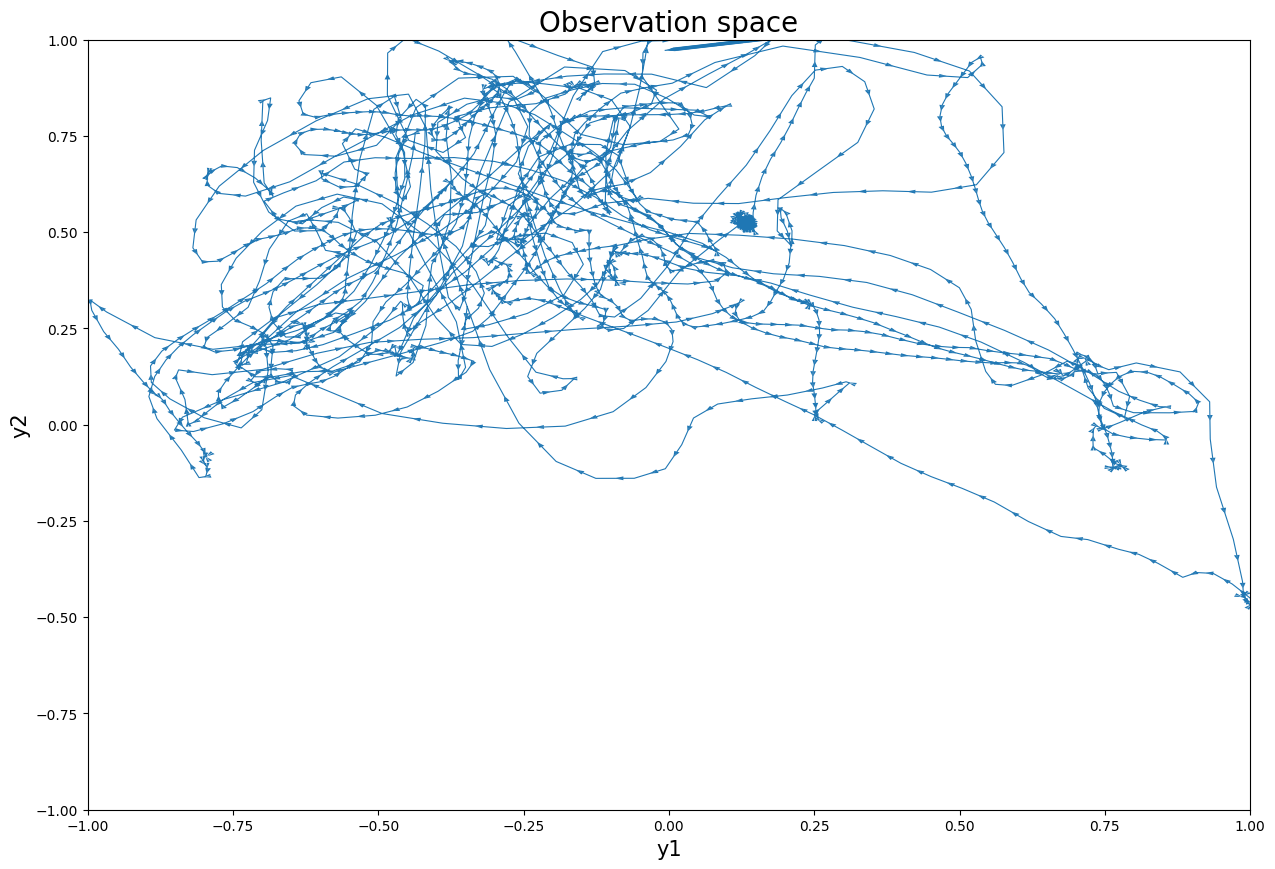

In [9]:
plt.rcParams["figure.figsize"] = (15,10)

plt.plot(y[:, 0], y[:, 1], lw = 0.8)

# code to add the arrows in the middle of the lines (fix head_width if needed)
for t in range(y.shape[0]-1):
    arr_mean_y1 = np.mean([y[t, 0], y[t+1, 0]])
    arr_mean_y2 = np.mean([y[t, 1], y[t+1, 1]])
    dy1 = y[t+1, 0] - y[t, 0]
    dy2 = y[t+1, 1] - y[t, 1]
    plt.arrow(arr_mean_y1, arr_mean_y2, 0.01*dy1, 0.01*dy2, shape='full', lw=0, length_includes_head=True, head_width=0.01)
    
plt.xlabel("y1", fontsize = 15)
plt.ylabel("y2", fontsize = 15)
plt.title("Observation space", fontsize = 20)
plt.xlim(-1,1)
plt.ylim(-1,1)

## Inference

In [10]:
# to generate a random semipositive matrix
def generate_random_semipositive_matrix(dim, scale):

    tm = np.random.randn(dim, dim)
    test_matrix = scale*np.dot(tm, tm.T)
    
    return test_matrix

In [12]:
T = y.shape[0] # number of time steps
N = 2 # observation dim
K = 5 # latent dim

L = 100 # how many Gibbs iteration to do

### PRIORS

# IW(Q_k; S, nu)
# MN(A_hat_k; C, Q_k, V)

S = np.array([1/120, 1/80])*np.eye(N, N) # 1 meter in each direction
nu = N

C = np.zeros((N, N+1))
C[:, 0] = np.zeros(N)
C[:, 1:] = np.eye(N, N)
V = 1*np.eye(N+1, N+1)

### INFERRED VARIABLES

# inferred samples of z
z_inf = np.zeros((L,T)).astype('int')
z_inf[0] = np.random.randint(K, size = T).astype('int')

# inferred samples of M
M_inf = np.zeros((L,K,K))
M_inf[0] = np.stack([np.random.dirichlet(tuple([1]*K)) for i in range(K)])

A_hat_inf = np.zeros((L, K, N, N+1))
A_hat_inf[0][:, :, 0] = 1*np.random.randn(K, N)
A_hat_inf[0][:, :, 1:] = 1*np.random.randn(K, N, N)

# inferred samples of Q_k
Q_inf = np.zeros((L,K,N,N))
Q_inf[0] = np.stack([np.array([1/120, 1/80])*np.eye(N, N) for k in range(K)])

# inferred alpha parameters for the conditional dirichlet (to sample M)
alpha_inf = np.ones((L,K,K))

In [13]:
b_inf = A_hat_inf[0][:,:,0]
A_inf = A_hat_inf[0][:,:,1:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


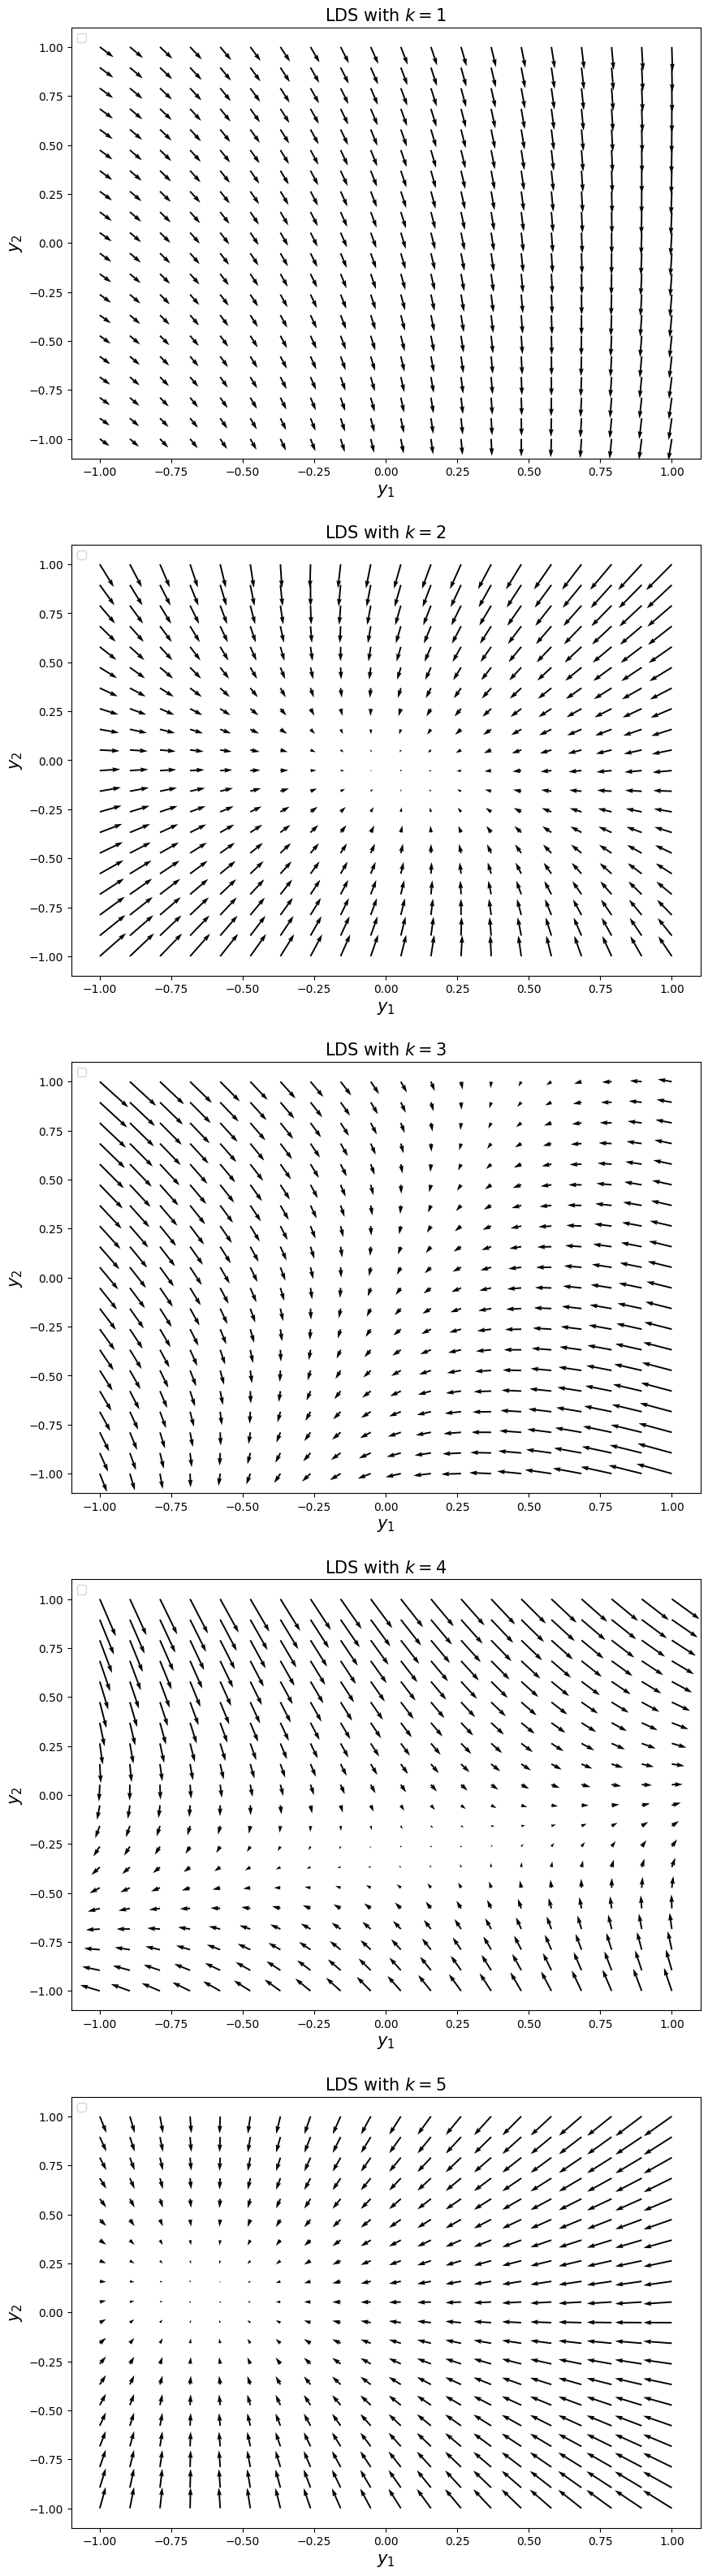

In [14]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf, b_inf, show_fixed_point = False)

In [15]:
### function to try to implement forward-backward algo

def message_passing(M_inf_l, A_hat_inf_l, Q_inf_l):

    log_m = [np.array([0]*K)] # list of log messages, the first one has all zeros

    for t in reversed(range(1,T)): # T-1, T-2, ...
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        somm = np.zeros((K, K))
        m_t = np.zeros(K) # log of message at time t
        for k in range(K):
            for j in range(K):
                rv = multivariate_normal(np.zeros(N), Q_inf_l[j])
                x = y[t] - np.dot(A_hat_inf_l[j], y_hat)
                somm[k,j] = np.log(M_inf_l[k,j]) + rv.logpdf(x) + log_m[T-1-t][j]

            m_t[k] = logsumexp(somm[k])
        
        log_m.append(m_t) # insert message in the list

    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    for k in range(K):
        log_p_z[0, k] = log_m[T-1][k]
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    for t in range(1,T):
        y_hat = np.concatenate([np.array([1]), y[t-1]])
        for k in range(K):
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = np.log(M_inf_l[z_inf_l[t-1],k]) + rv.logpdf(x) + log_m[T-1-t][k]
        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    return z_inf_l

In [16]:
### my version of sampling z_t

def myconditionals(M_inf_l, A_hat_inf_l, Q_inf_l, z_inf_prec):

    # discrete conditional distribution P(z_t|...) at each time 1,...,T
    p_z = np.zeros((T, K))
    log_p_z = np.zeros((T, K))
    z_inf_l = np.zeros(T).astype('int')

    # P(z_1|...)
    for k in range(K):
        log_p_z[0, k] = np.log(M_inf_l[z_inf_prec[1], k])
    log_p_z[0] = log_p_z[0] - logsumexp(log_p_z[0])
    z_inf_l[0] = np.random.choice(K, p = np.exp(log_p_z[0]))

    # P(z_t|...) for t in 2:T-1
    for t in range(1, T-1):
        for k in range(K):
            y_hat = np.concatenate([np.array([1]), y[t-1]])
            rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
            x = y[t] - np.dot(A_hat_inf_l[k], y_hat)
            log_p_z[t, k] = rv.logpdf(x) + np.log(M_inf_l[z_inf_prec[t+1], k] * M_inf_l[k, z_inf_l[t-1]])
            #print(rv.pdf(x))

        log_p_z[t] = log_p_z[t] - logsumexp(log_p_z[t])
        z_inf_l[t] = np.random.choice(K, p = np.exp(log_p_z[t]))

    # P(z_T|...)        
    for k in range(K):
        y_hat = np.concatenate([np.array([1]), y[T-2]])
        rv = multivariate_normal(np.zeros(N), Q_inf_l[k])
        x = y[T-1] - np.dot(A_hat_inf_l[k], y_hat)
        log_p_z[T-1, k] = rv.logpdf(x) + np.log(M_inf_l[k, z_inf_l[T-2]])
    log_p_z[T-1] = log_p_z[T-1] - logsumexp(log_p_z[T-1])
    z_inf_l[T-1] = np.random.choice(K, p = np.exp(log_p_z[T-1]))

    return z_inf_l


In [0]:
### Gibbs sampling loop, update in sequence: z, M, A_hat, Q

for l in tqdm(range(L-1)):
    
    #print("\n SAMPLE:", l)
    
    ### UPDATE z_t

    z_inf[l+1] = message_passing(M_inf[l], A_hat_inf[l], Q_inf[l])
    #z_inf[l+1] = myconditionals(M_inf[l], A_hat_inf[l], Q_inf[l], z_inf[l])

    ## UPDATE M
    
    # computing how many times there is a transition from state k to state j
    chi = np.zeros((K, K))
    
    for k in range(K):
        for j in range(K):
            somm = 0
            for t in range(T-1):
                if z_inf[l+1, t] == k and z_inf[l+1, t+1] == j:
                    somm += 1
            chi[k, j] = somm
    
    # updating conditional dirichlet parameters alpha initially set to [1,1,...,1] matrix
    alpha_inf[l+1] += chi
    
    # sampling rows of M from conditional distribution P(M|alpha)
    for k in range(K):
        M_inf[l+1, k] = np.random.dirichlet(tuple(alpha_inf[l+1, k]))
        
    #print(" \n alpha:")
    #print(alpha_inf[l+1])
    
    ### UPDATE MODEL PARAMETERS (see overleaf)
    
    # create data matrix grouped by state, all y_t where z_t = k
    Y = [[] for k in range(K)]

    # create data matrix grouped by state, all y_{t-1} where z_t = k
    Y_bar = [[] for k in range(K)]

    # number of observations belonging to a given state k
    N_k = np.zeros(K)
    
    #print("\n N_k:")
    
    for k in range(K):
        for t in range(1, T):
            if z_inf[l+1, t] == k:
                Y[k].append(y[t])
                Y_bar[k].append(np.concatenate([np.array([1]), y[t-1]]))
    
        N_k[k] = len(Y[k])
        #print(N_k[k])
        if N_k[k] != 0:
            Y[k] = np.stack(Y[k]).T
            Y_bar[k] = np.stack(Y_bar[k]).T
        
    # sufficient statistics for MNIW (see overleaf)
    
    S_ybar_ybar = np.zeros((K, N+1, N+1))
    S_y_ybar = np.zeros((K, N, N+1))
    S_y_y = np.zeros((K, N, N))
    S_y_given_ybar = np.zeros((K, N, N))
    
    for k in range(K):
        if N_k[k] != 0:
            #print(Y_bar[k].shape)
            S_ybar_ybar[k] = np.dot(Y_bar[k], Y_bar[k].T) + V
            S_y_ybar[k] = np.dot(Y[k], Y_bar[k].T) + np.dot(C, V)
            S_y_y[k] = np.dot(Y[k], Y[k].T) + C @ V @ C.T
            S_y_given_ybar[k] = S_y_y[k] - S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]) @ S_y_ybar[k].T
    
    # sampling from IW and MN with updated hyperparameters
    
    for k in range(K):
        if N_k[k] != 0:
            rv_iw = invwishart(nu + N_k[k], S + S_y_given_ybar[k])
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            
            # INVERSE OF Q OR NOT?
            rv_mn = matrix_normal(S_y_ybar[k] @ np.linalg.inv(S_ybar_ybar[k]), Q_inf[l+1, k], np.linalg.inv(S_ybar_ybar[k]))
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)
        else:
            # keep the same o sample a fresh new? (from the priors maybe)
            rv_iw = invwishart(nu, S)
            Q_inf[l+1, k] = rv_iw.rvs(size = 1)
            rv_mn = matrix_normal(C, Q_inf[l+1, k], V)
            A_hat_inf[l+1, k] = rv_mn.rvs(size = 1)

            #Q_inf[l+1, k] = Q_inf[l, k] 
            #A_hat_inf[l+1, k] = 1*np.random.randn(N, N+1)

100%|██████████| 99/99 [33:09<00:00, 20.10s/it]


In [26]:
def compute_mean_z(inferred_z):
    # mean_z of a certain number of samples, following majority rule
    mean_z = np.zeros(T).astype('int')
    for t in range(T):
        mean_z[t] = np.argmax(np.bincount(inferred_z[:, t]))
    return mean_z

In [27]:
# analysing inferred z at different epochs of the gibbs sampler
z_mean = compute_mean_z(z_inf[L//2:])
print(z_inf[0])
print(z_inf[1])
print(z_inf[-1])
print(z_mean)
#print(np.mean(z_inf, axis = 0)) 
unique, counts = np.unique(z_inf[L//2:], return_counts=True)
print(dict(zip(unique, counts)))

[3 1 4 ... 4 0 2]
[1 4 4 ... 2 2 2]
[3 3 3 ... 2 2 2]
[3 3 3 ... 2 2 2]
{0: 16292, 1: 20363, 2: 25371, 3: 15494, 4: 15930}


In [20]:
used_states = []
for l in range(L):
    unique, counts = np.unique(z_inf[l], return_counts=True)
    used_states.append(unique)

print(used_states)

[array([0, 1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([1, 2, 3, 4]), array([1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]), arr

In [21]:
M_mean = np.mean(M_inf[L//2:], axis = 0) # best estimate for M
print(M_mean)
eigw_inf, eigv_inf = np.linalg.eig(M_mean.T)
print(eigv_inf.real[:, 0]/np.sum(eigv_inf.real[:, 0])) # stationary distribution of Prob(z)

[[0.83841945 0.0345665  0.03982401 0.05939093 0.02779911]
 [0.02905101 0.89273877 0.01481434 0.03520531 0.02819057]
 [0.01243877 0.02883942 0.93623529 0.00391869 0.01856783]
 [0.04627931 0.03151423 0.00763761 0.83730027 0.07726859]
 [0.06483252 0.03012516 0.0372472  0.03652289 0.83127223]]
[0.17390792 0.22387816 0.27761998 0.15637415 0.16821979]


In [22]:
A_hat_mean = np.mean(A_hat_inf[L//2:], axis = 0) # best estimate for A_hat
print(A_hat_mean)

[[[ 0.01725819  1.01088962  0.02672918]
  [ 0.02235527 -0.04714239  1.00887514]]

 [[ 0.00881075  1.00729114  0.01052063]
  [-0.01434615  0.01136049  0.9788054 ]]

 [[ 0.0060394   0.97140283 -0.00315595]
  [ 0.00376476 -0.02052624  0.99775429]]

 [[-0.05082515  0.99730962  0.01198843]
  [-0.00303714  0.03636816  0.97151868]]

 [[-0.0207631   0.97491642  0.00913799]
  [ 0.01632444  0.01553535  0.98719589]]]


In [23]:
Q_mean = np.mean(Q_inf[L//2:], axis = 0) # best estimate for Q
for k in range(K):
    print(Q_mean[k])
    eigw_q, _ = np.linalg.eig(Q_mean[k]) # eigenvalues of Q_k
    print(eigw_q, "\n")

[[ 0.00130191 -0.00070344]
 [-0.00070344  0.00226332]]
[0.00093061 0.00263462] 

[[1.96185260e-04 4.99707333e-05]
 [4.99707333e-05 2.82111443e-04]]
[0.00017325 0.00030505] 

[[ 3.38249743e-05 -2.13163734e-06]
 [-2.13163734e-06  8.37130932e-05]]
[3.37340587e-05 8.38040089e-05] 

[[ 0.0006985  -0.00020503]
 [-0.00020503  0.00167118]]
[0.00065705 0.00171263] 

[[1.83874513e-04 1.14269357e-05]
 [1.14269357e-05 3.55059681e-04]]
[0.00018312 0.00035582] 



In [24]:
# best estimate for A_hat decomposition in A and b, in order to plot the lds
b_inf_av = A_hat_mean[:,:,0]
A_inf_av = A_hat_mean[:,:,1:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


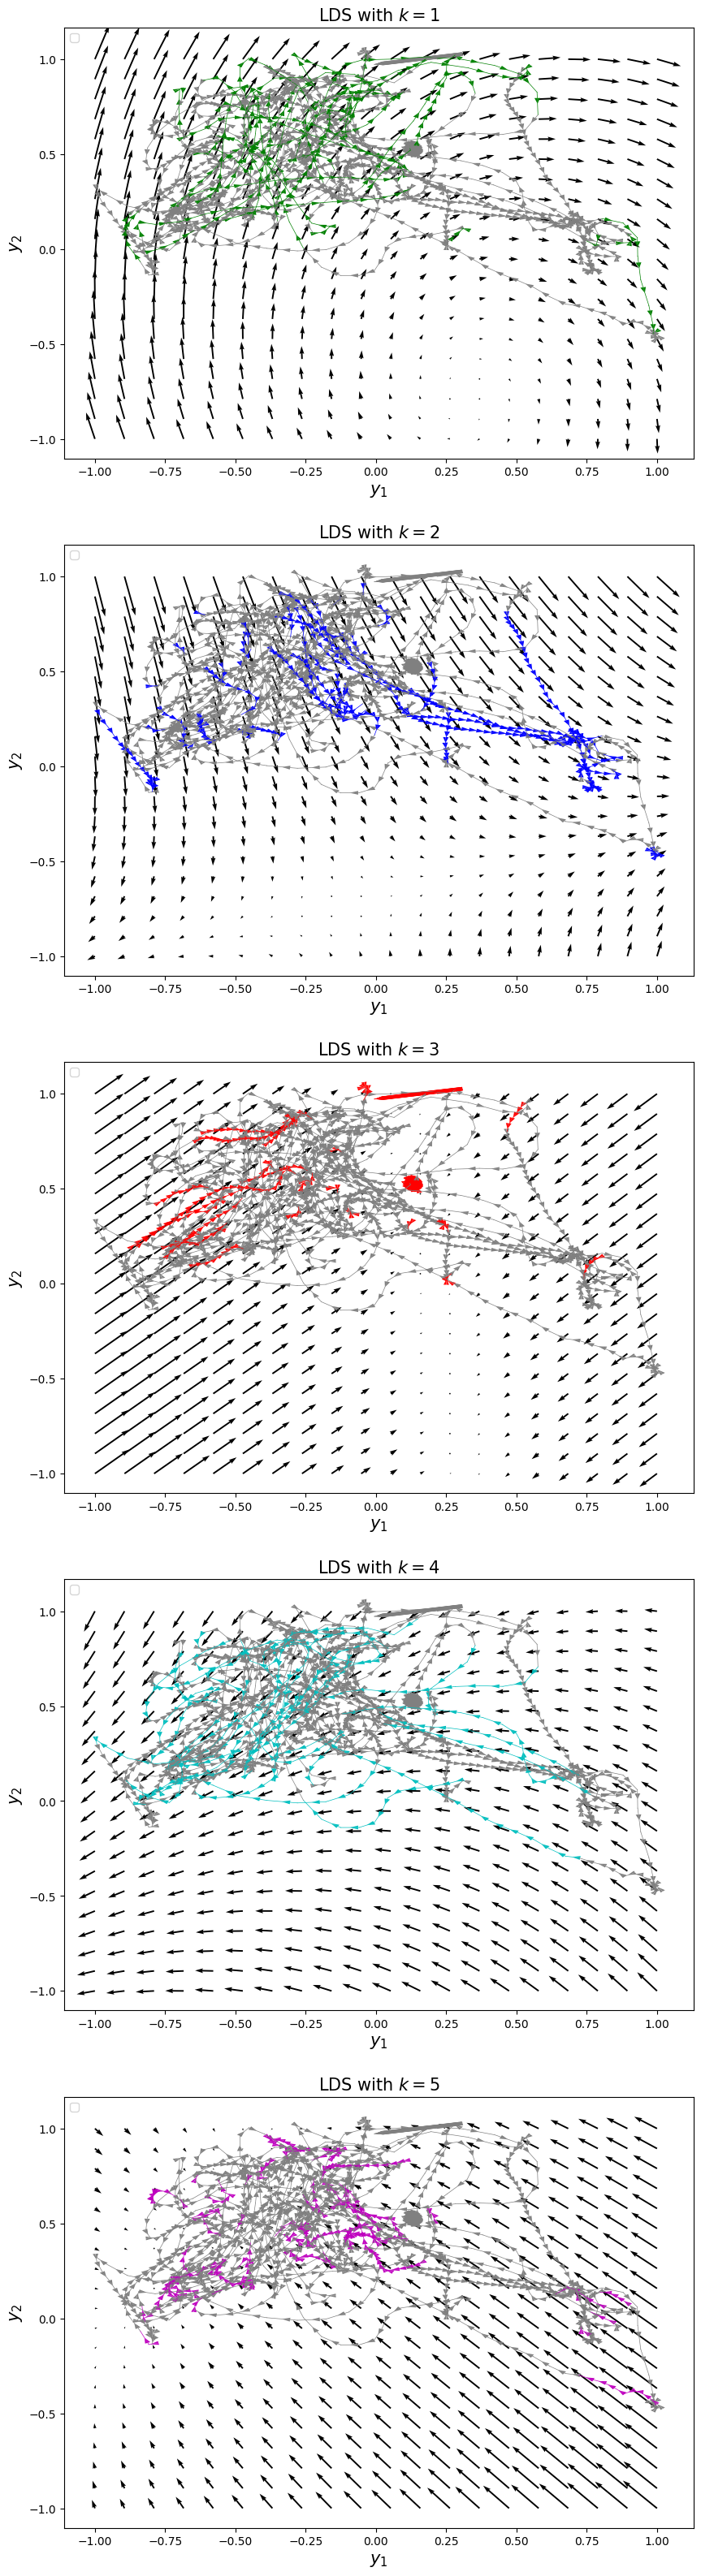

In [25]:
# create a grid just to display the dynamic systems
x1, x2 = np.linspace(-1,1,20), np.linspace(-1,1,20)
X1, X2 = np.meshgrid(x1, x2)

plot_latent_state_dynamic(X1, X2, A_inf_av, b_inf_av, show_fixed_point = False, show_states = True, z = z_mean)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7418b957-40c0-4b8c-8b59-f82ba42a5a5a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>